## Downloading all the necessary libraries

In [1]:
!pip install torch
!pip install numpy
!pip install matplotlib
!pip install pandas
!pip install time
!pip install dataclasses

print("complete")

ERROR: Could not find a version that satisfies the requirement time (from versions: none)
ERROR: No matching distribution found for time


complete


## Importing all the necessary libraries

In [3]:
import torch
from torch import nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
from dataclasses import dataclass
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset

data = pd.read_csv("PJM(AEP)_energy_dataset.csv")
data.head()

,Datetime,PJME_MW
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0


## Graphing the data per hour

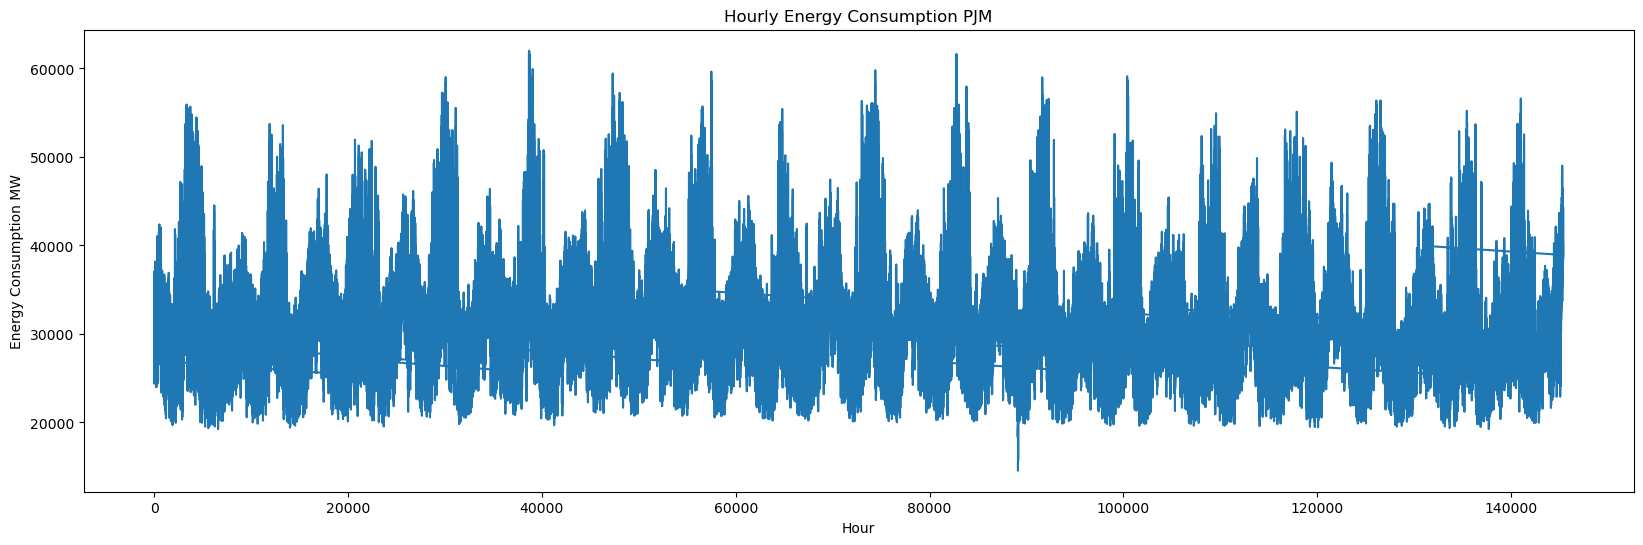

In [5]:
data = data.sort_values(by="Datetime")

plt.figure(figsize=(20, 6))
plt.plot(data["PJME_MW"])
plt.xlabel("Hour")
plt.ylabel("Energy Consumption MW")
plt.title("Hourly Energy Consumption PJM")
plt.show()

## Dividing the data into x and y values, in order to fully implement the machine learning technique

In [7]:
data_series = data["PJME_MW"].tolist()
num = 100

data_x, data_y = [], []

for i in range(len(data_series) - num):
    data_x.append(data_series[i : i + num])
    data_y.append(data_series[i + num])

print(data_x[:2])
print(data_y[:2])

[[30393.0, 29265.0, 28357.0, 27899.0, 28057.0, 28654.0, 29308.0, 29595.0, 29943.0, 30692.0, 31395.0, 31496.0, 31031.0, 30360.0, 29798.0, 29720.0, 31271.0, 35103.0, 35732.0, 35639.0, 35285.0, 34007.0, 31857.0, 29563.0, 28121.0, 27437.0, 27301.0, 27533.0, 28405.0, 30748.0, 34725.0, 37313.0, 37322.0, 37035.0, 36758.0, 36284.0, 35548.0, 34978.0, 34304.0, 34169.0, 35674.0, 39532.0, 40002.0, 39484.0, 38693.0, 37016.0, 34332.0, 31451.0, 29414.0, 28537.0, 28118.0, 28106.0, 28650.0, 30687.0, 34696.0, 37196.0, 37436.0, 37323.0, 37198.0, 36548.0, 36024.0, 35186.0, 34478.0, 34497.0, 35807.0, 39261.0, 39662.0, 39177.0, 38328.0, 36636.0, 33869.0, 31038.0, 29338.0, 28421.0, 28145.0, 28122.0, 28637.0, 30540.0, 34579.0, 36958.0, 36721.0, 36318.0, 35809.0, 35333.0, 34639.0, 34237.0, 33577.0, 33352.0, 34563.0, 37710.0, 38263.0, 37539.0, 36762.0, 35368.0, 33202.0, 30924.0, 28635.0, 27501.0, 27034.0, 26669.0], [29265.0, 28357.0, 27899.0, 28057.0, 28654.0, 29308.0, 29595.0, 29943.0, 30692.0, 31395.0, 31496.

## Creating the general model architecture

In [9]:
@dataclass
class Config():
    sequence_length = 100
    mlp1_output_size = 120
    mlp2_output_size = 60

class Model(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.mlp1 = MLP1(config)
        self.layer_norm1 = nn.LayerNorm(config.mlp1_output_size)
        self.attention_mechanism = AttentionMechanism(config)
        self.layer_norm2 = nn.LayerNorm(config.mlp1_output_size)
        self.mlp2 = MLP2(config)
        self.linear = nn.Linear(config.mlp2_output_size, 1)

    def forward(self, x):
        x = self.mlp1(x)
        x = self.layer_norm1(x)
        x = self.attention_mechanism(x)
        x = self.layer_norm2(x)
        x = self.mlp2(x)
        x = self.linear(x)
        return x    

## Creating both multi-perceptron layers

In [11]:
class MLP1(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.f1 = nn.Linear(config.sequence_length, 60)
        self.r1 = nn.ReLU()
        self.f2 = nn.Linear(60, config.mlp1_output_size)

    def forward(self, x):
        x = self.f1(x)
        x = self.r1(x)
        x = self.f2(x)
        return x

class MLP2(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.f1 = nn.Linear(config.mlp1_output_size, 80)
        self.r1 = nn.ReLU()
        self.f2 = nn.Linear(80, config.mlp2_output_size)

    def forward(self, x):
        x = self.f1(x)
        x = self.r1(x)
        x = self.f2(x)
        return x  

## Creating attention-mechanism

In [13]:
class AttentionMechanism(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.queries = nn.Linear(config.mlp1_output_size, config.mlp1_output_size)
        self.keys = nn.Linear(config.mlp1_output_size, config.mlp1_output_size)
        self.values = nn.Linear(config.mlp1_output_size, config.mlp1_output_size)
        self.final_linear = nn.Linear(config.mlp1_output_size, config.mlp1_output_size)

    def forward(self, x):
        queries = self.queries(x)
        keys = self.keys(x)
        values = self.values(x)
        scores = torch.matmul(queries, keys.T) / (self.config.mlp1_output_size ** 0.5)
        scores = torch.softmax(scores, dim=1)
        output = torch.matmul(scores, values)
        output = self.final_linear(output)
        return output


## Creating the system/training

In [15]:
class System():
    def __init__(self, config):
        self.model = Model(config)
        self.optimizer = optim.Adam(self.model.parameters(), lr=3e-4)
        self.criterion = nn.MSELoss()
        self.X_scaler = MinMaxScaler()
        self.y_scaler = MinMaxScaler()
        
    def fit_scalers(self, X_train, y_train):
        self.X_scaler.fit(np.array(X_train).reshape(-1, 1))
        self.y_scaler.fit(np.array(y_train).reshape(-1, 1))
        
    def scale_data(self, data, scaler, func):
        data = np.array(data).reshape(-1, 1)
        if func == 1:
            return scaler.transform(data).flatten()
        elif func == 0:
            return scaler.inverse_transform(data).flatten()
        else:
            raise ValueError("Invalid scaling function code (must be 0 or 1).")
            
    def train(self, epochs, X_train, y_train, batch_size=64):
        self.fit_scalers(X_train, y_train)
        
        X_train = self.scale_data(X_train, self.X_scaler, 1)
        y_train = self.scale_data(y_train, self.y_scaler, 1)
        
        X_train = torch.tensor(X_train, dtype=torch.float32).view(-1, 100)
        y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
        
        dataset = TensorDataset(X_train, y_train)
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
        
        for epoch in range(epochs):
            for batch_X, batch_y in dataloader:
                self.optimizer.zero_grad()
                predictions = self.model(batch_X)
                loss = self.criterion(predictions, batch_y)
                loss.backward()
                self.optimizer.step()
                
            print(f"Epoch {epoch + 1}: Loss = {loss.item()}")

## Compiling everything together into one class

In [17]:
class Tools():
    def __init__(self, config):
        self.system = System(config)

    def train(self, epochs, X_train, y_train):
        self.system.train(epochs, X_train, y_train)

    def predict(self, x):
        x = self.system.scale_data(x, self.system.X_scaler, 1)
        x = torch.tensor(x, dtype=torch.float32).view(-1, 100)
        y = self.system.model(x)
        y = y.detach().numpy()
        y = self.system.scale_data(y, self.system.y_scaler, 0)
        return y

    def train_accuracy(self, X_train, y_train):
        predictions = self.predict(X_train)
        
        plt.plot(y_train, label="True")
        plt.plot(predictions, label="Predicted")
        plt.title("Train Accuracy")
        plt.legend()
        plt.show()

## Making the test function

In [19]:
import matplotlib.pyplot as plt

def test_accuracy_individual(X_train, y_train, X_test, y_test, config, epochs):
    tools = Tools(config)
    tools.train(epochs, X_train, y_train)
    predictions = tools.predict(X_test)
    
    plt.plot(y_test, label="True")
    plt.plot(predictions, label="Predicted")
    plt.title("Test Accuracy")
    plt.legend()
    plt.show()


def test_accuracy_whole_predictions(X_test, y_test, X_train, y_train, config):
    tools = Tools(config)
    tools.train(100, X_train, y_train)

    output_list = []

    for i in range(2000):
        output = tools.predict(X_test[:100])
        output_list.append(output)
        X_test = np.concatenate((X_test[1:], [output]))

    predicted_values = np.array(output_list).flatten()

    figure, axis = plt.subplots(1, 2, figsize=(10, 5))
        
    axis[0].plot(range(2000), predicted_values, label="Predicted")
    axis[0].set_title("Predicted Values")
    axis[0].legend()

    axis[1].plot(range(2000), y_test[:2000], label="True")
    axis[1].set_title("True Values")
    axis[1].legend()
    
    plt.tight_layout()
    plt.show()

## Train Accuracy

In [ ]:
config = Config()
tools = Tools(config)
tools.train(10, data_x, data_y)
tools.train_accuracy(data_x, data_y)

Epoch 1: Loss = 0.0008139056153595448
Epoch 2: Loss = 0.00022000526951160282
Epoch 3: Loss = 0.0009016630938276649
Epoch 4: Loss = 0.0004829330136999488
Epoch 5: Loss = 0.0002452559710945934
Epoch 6: Loss = 0.00018323937547393143
Epoch 7: Loss = 9.530052193440497e-05
Epoch 8: Loss = 0.000260563800111413
Epoch 9: Loss = 0.00012848046026192605
Epoch 10: Loss = 0.00023571899509988725


## Individual Test Accuracy

In [ ]:
train_index = 1151
X_train = data_x[:1151]
y_train = data_y[:1151]

X_test = data_x[1151:]
y_test = data_y[1151:]

config = Config()
test_accuracy_individual(X_train, y_train, X_test, y_test, config, 300)
